# Coursera Applied Data Science Capstone
### Final Assignment Submission
##### Lionel K

<b>Situation:</b> Our client is a prominent "Buyer's Agent" whose business is based on finding and transacting on property sales for the buyer(s), rather than for the vendor (seller). They take requirements and instructions from Buyers, then seek out properties for those Buyers to consider purchasing. Once a property is chosen, our client the Buyer's Agent will also undertake actions to acquire the chosen property for the Buyer. Our client wishes to use data, analytics and data science to guide their Buyer's choices, therefore giving their agency a way to differentiate from their competitors.

<b>Complication:</b> Most Buyer's Agencies operate in the market in an 'intuitive' way, based on their market knowledge and experience. For example, if a Buyer says they are looking for a country lifestyle with access to schools, the areas recommended to them are often based on that particular Buyer's Agent's own knowledge and experience from previous sales. 

<b>Problem Statement:</b> How can we use data, analytics and data science to make informed recommendations on locations for Buyer's, based on their individual requirements.

<b>Use Case:</b> As a pilot project, our client has provided us with a Use Case for a proof of concept. The 'Buyer' in question is a successful middle aged couple, without children. They are relocating to Toronto from Melbourne, Australia and wish to use the move for a change of lifestyle. They have no intention of starting a family, but have grown tired of living in a busy city area. They both work for home / remotely and do not have to travel to an office.

They explicitly told the Buyer's Agent: <i>"When not working, we spend about 30% of our time dining out, and probably the same again going out to bars and other nightlife, and public amenities like parks and museums. We spend about 20% of our time shopping, and divide the remainder equally between fitness and entertainment. We want a property about 30 mins away from the Toronto CBD by car, but in a location with similar conveniences and facilities that you would find in a downtown area"</i>



In [ ]:
# Install required packages 
!pip install beautifulsoup4
!pip install geopy
!pip install folium==0.7.0

In [214]:
# Import libraries to be used
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests, time, random, json, folium, math
from geopy.geocoders import Nominatim
from IPython.display import Image 
from IPython.core.display import HTML 
from pandas.io.json import json_normalize
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.cm as cm
import matplotlib.colors as colors

In [25]:
pd.set_option('display.max_rows', 20)

##### Scrape Table of Postcodes from Wikipedia page

In [7]:
# Define a function to scrape table using Beautiful Soup
def scrape_table():
    # get contents of url and parse to html using Beautiful Soup
    r = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
    print(r.status_code)  # Print the status code
    content = r.text
    summary_items=[]
    soup = BeautifulSoup(content, "html.parser")
    
    # read the table and save to list "data", and return 
    data = []
    table = soup.find('table', attrs={'class':'wikitable sortable'})
    table_body = table.find('tbody')
    # print(table_body)
    rows = table_body.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele]) # Get rid of empty values
    return data

In [8]:
# Call scrape_table function to return list
scrape = scrape_table()

200


In [9]:
# Create DF from list and label columns
df_Scrape0 = pd.DataFrame(scrape, columns = ['Postcode' , 'Borough', 'Neighbourhood']) 
df_Scrape0.shape

(288, 3)

In [10]:
df_Scrape0.head(5)

,Postcode,Borough,Neighbourhood
0,None,None,None
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village


In [11]:
# Drop row 0 which returned NaNs from scrape
df_Scrape0.drop(0, inplace=True)
df_Scrape0.reset_index(inplace=True)

In [12]:
df_Scrape0.head(5)

,index,Postcode,Borough,Neighbourhood
0,1,M1A,Not assigned,Not assigned
1,2,M2A,Not assigned,Not assigned
2,3,M3A,North York,Parkwoods
3,4,M4A,North York,Victoria Village
4,5,M5A,Downtown Toronto,Harbourfront


##### Only use cells that have an assigned borough. Ignore cells with a Borough that is 'Not assigned'.

In [13]:
# Create bool DF of Boroughs with 'Not assigned' value
df_BoroughNA = (df_Scrape0['Borough'] != ('Not assigned')).to_frame()
df_BoroughNA.columns=['BoroughNA']

# Create Index List where bool == True and drop rows from data 
idx = df_BoroughNA[~(df_BoroughNA['BoroughNA']==True)].index
df_postcodes1 = df_Scrape0.drop(idx)
df_postcodes1.reset_index(inplace=True)
df_postcodes1.shape

(210, 5)

##### More than one neighborhood can exist in one postal code area. These rows will be combined into one row with the neighborhoods separated with a comma.

<i><u>PLEASE NOTE</i></u>:
Neighbourhood <b>Regent Park</b> <i><u>does not</i></u> appear of the Wikipedia page, as described by the Coursera assignment instructions. It has possibly been removed from the wiki since the course has been written. Hence, postcode <b>M5A</b> does not match two Neighbourhoods, as described.

In [14]:
# Drop any duplicates of Postcode and Borough
tmp = df_postcodes1[['Postcode','Borough']].drop_duplicates()
tmp.reset_index(drop=True, inplace=True)

In [15]:
# Combine Neighbourhoods with same Postcode
Grp_Neighbourhood  = df_postcodes1.groupby('Postcode')['Neighbourhood'].apply(lambda x: "%s" % ', '.join(x)).to_frame()
Grp_Neighbourhood.reset_index(inplace=True)
Grp_Neighbourhood.columns=['Postcode','Neighbourhoods']

In [16]:
# Merge Deduped list of Postcode and Boroughs with Combined Neighbourhoods
merged0 = tmp.merge(Grp_Neighbourhood, left_on='Postcode', right_on='Postcode', how='left')

##### If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

In [17]:
# Replace Neighbourhoods with 'Not assigned' value with Borough value
merged0['Neighbourhoods'] = np.where((merged0.Neighbourhoods == 'Not assigned'),merged0.Borough,merged0.Neighbourhoods)

In [18]:
# See sample of final dataframe
merged0.head(10)

,Postcode,Borough,Neighbourhoods
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park
5,M9A,Downtown Toronto,Queen's Park
6,M1B,Scarborough,"Rouge, Malvern"
7,M3B,North York,Don Mills North
8,M4B,East York,"Woodbine Gardens, Parkview Hill"
9,M5B,Downtown Toronto,"Ryerson, Garden District"


In [19]:
# Output shape of final dataframe
merged0.shape

(103, 3)

##### Read Geospatial Data from CSV 

In [21]:
df_geo = pd.read_csv('http://cocl.us/Geospatial_data')
df_geo.head(5)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [26]:
# Merge coordinates
merged1 = merged0.merge(df_geo, left_on='Postcode', right_on='Postal Code', how='left')
merged1.drop('Postal Code', axis=1)

,Postcode,Borough,Neighbourhoods,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494
5,M9A,Downtown Toronto,Queen's Park,43.667856,-79.532242
6,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


### Plot location of Postcodes on map

In [28]:
# create map of Toronto's Boroughs using latitude and longitude values
# Toronto coordinates are 43.6532° N, 79.3832° W
map_toronto = folium.Map(location=[43.6532, -79.3832], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(merged1['Latitude'], merged1['Longitude'], merged1['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

### Extract Foursquare Data using API

In [ ]:
CLIENT_ID = 'XXX' # Foursquare ID
CLIENT_SECRET = 'XXX' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

In [30]:
postcode_list = merged1['Postcode'].tolist()
N = len(postcode_list)

##### I want to compare postcodes in Toronto using the categories / types of venues as characteristics of each postcode. Therefore, I iterated over the latitude and longitude of each postcode and accessed FourSquare's API to extract the 100 most popular locations within a 1km radius of each postcode

In [37]:
# Create a for loop to iterate and collect 'Explore' call data from Foursquare, for each postcode
i=0
for i in range(N):
    postcode_lat = merged1.loc[i, 'Latitude'] # neighborhood latitude value
    postcode_lng = merged1.loc[i, 'Longitude'] # neighborhood longitude value
    postcode = merged1.loc[i, 'Postcode'] # postcode
    neighbourhood_name = merged1.loc[i, 'Neighbourhoods'] # neighborhood name
    # print('Latitude and longitude values of {} {} are {}, {}.'.format(postcode, neighbourhood_name, postcode_lat, postcode_lng))
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, postcode_lat, postcode_lng, radius,LIMIT)
    
    print('Collecting data for Latitude and longitude values of {} {} {}, {}.'.format(postcode, neighbourhood_name, postcode_lat, postcode_lng))
    
    results = requests.get(url).json() 
    # print(results)

    # assign relevant part of JSON to venues
    venues = results['response']['groups'][0]['items']

    # tranform venues into a dataframe
    df_explore0 = json_normalize(venues)
       
    df_explore0['expl_pcode'] = merged1.loc[i, 'Postcode']
    df_explore0['expl_borough'] = merged1.loc[i, 'Borough']
    df_explore0['expl_nhoods'] = merged1.loc[i, 'Neighbourhoods']
    df_explore0['expl_lat'] = merged1.loc[i, 'Latitude']
    df_explore0['expl_lng'] = merged1.loc[i, 'Longitude']
    
    if i==0: 
        df_4sqexpl0 = df_explore0
    else:
        df_4sqexpl0 = df_4sqexpl0.append(df_explore0, sort=False)
        
    i=i+1

In [38]:
df_4sqexpl0.head(1)

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,...,venue.photos.count,venue.photos.groups,expl_pcode,expl_borough,expl_nhoods,expl_lat,expl_lng,venue.venuePage.id,venue.events.count,venue.events.summary
0,0.0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4b8991cbf964a520814232e3-0,"[{'id': '4bf58dd8d48988d144941735', 'name': 'C...",4b8991cbf964a520814232e3,81 Underhill drive,CA,Toronto,Canada,NaN,...,0.0,[],M3A,North York,Parkwoods,43.753259,-79.329656,NaN,NaN,NaN


In [39]:
# filter columns
filtered = ['expl_pcode','expl_borough','expl_nhoods','expl_lat','expl_lng','venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_4sqexpl1 = df_4sqexpl0.loc[:, filtered]

# filter the category for each row
df_4sqexpl1['venue.categories'] = df_4sqexpl1.apply(get_category_type, axis=1)
    
# clean columns
df_4sqexpl1.columns = [col.split(".")[-1] for col in df_4sqexpl1.columns]
    
df_4sqexpl1.rename(columns={'name':'venue_nm','categories':'venue_cat','lat':'venue_lat','lng':'venue_lng' }, inplace=True)

In [40]:
df_4sqexpl1.dtypes

expl_pcode       object
expl_borough     object
expl_nhoods      object
expl_lat        float64
expl_lng        float64
venue_nm         object
venue_cat        object
venue_lat       float64
venue_lng       float64
dtype: object

In [116]:
df_4sqexpl1.shape

(4882, 10)

### Import and merge pre-defined Foursqaure venue categories to types csv

In [43]:
# The code was removed by Watson Studio for sharing.

,venue_cat,venue_type
0,Caribbean Restaurant,Dining
1,Park,Amenities
2,Fast Food Restaurant,Dining
3,Café,Cafe
4,Grocery Store,Shopping


In [117]:
# Merge on venue_type element
df_4sqexpl2 = df_4sqexpl1.merge(df_venuetype, left_on='venue_cat', right_on='venue_cat', how='left')

In [118]:
df_4sqexpl2.head(5)

,expl_pcode,expl_borough,expl_nhoods,expl_lat,expl_lng,venue_nm,venue_cat,venue_lat,venue_lng,dist,venue_type
0,M3A,North York,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,Caribbean Restaurant,43.759840,-79.324719,0.008228,Dining
1,M3A,North York,Parkwoods,43.753259,-79.329656,Brookbanks Park,Park,43.751976,-79.332140,0.002796,Amenities
2,M3A,North York,Parkwoods,43.753259,-79.329656,A&W Canada,Fast Food Restaurant,43.760643,-79.326865,0.007895,Dining
3,M3A,North York,Parkwoods,43.753259,-79.329656,Tim Hortons,Café,43.760668,-79.326368,0.008107,Cafe
4,M3A,North York,Parkwoods,43.753259,-79.329656,Bruno's valu-mart,Grocery Store,43.746143,-79.324630,0.008712,Shopping


### Let's take a look at the number of each venue type in every suburb in Toronto
##### Sum venues by postcode and venue type  

In [69]:
result = df_4sqexpl2.groupby(['expl_pcode','venue_type']).size()
df_result = pd.DataFrame(result)
df_result.reset_index(inplace=True)
df_result.columns = ['expl_pcode','venue_type','count_venues']

In [119]:
df_result.head(5)

,expl_pcode,venue_type,count_venues
0,M1B,Amenities,1
1,M1B,Dining,7
2,M1B,Entertainment,1
3,M1B,Fitness,1
4,M1B,Shopping,4


##### Print statistics for each postcode

In [98]:
df_result.groupby('expl_pcode').describe()

count_venues                                                
                  count      mean       std  min   25%  50%   75%   max
expl_pcode                                                             
M1B                 5.0  2.800000  2.683282  1.0  1.00  1.0  4.00   7.0
M1C                 2.0  2.500000  0.707107  2.0  2.25  2.5  2.75   3.0
M1E                 4.0  5.500000  5.259911  1.0  1.00  5.0  9.50  11.0
M1G                 3.0  3.000000  1.000000  2.0  2.50  3.0  3.50   4.0
M1H                 6.0  5.000000  5.440588  1.0  1.25  2.0  9.50  12.0
M1J                 4.0  3.000000  2.828427  1.0  1.00  2.0  4.00   7.0
M1K                 5.0  4.600000  4.505552  1.0  1.00  2.0  9.00  10.0
M1L                 9.0  2.777778  2.223611  1.0  1.00  2.0  3.00   7.0
M1M                 4.0  2.750000  2.362908  1.0  1.00  2.0  3.75   6.0
M1N                 6.0  2.166667  1.471960  1.0  1.00  1.5  3.50   4.0
...                 ...       ...       ...  ...   ...  ...   ...   ...
M9A                 5.0  2.400000  2.073644  1.0  1.00  2.0  2.00   6.0
M9B                 6.0  2.666667  1.861899  1.0  1.00  2.5  4.00   5.0
M9C                 6.0  2.833333  4.020779  1.0  1.00  1.0  1.75  11.0
M9L                 4.0  3.000000  2.828427  1.0  1.00  2.0  4.00   7.0
M9M                 6.0  1.500000  0.836660  1.0  1.00  1.0  1.75   3.0
M9N                 4.0  4.000000  2.309401  2.0  2.00  4.0  6.00   6.0
M9P                 4.0  3.500000  2.645751  1.0  1.75  3.0  4.75   7.0
M9R                 5.0  3.200000  2.949576  1.0  1.00  2.0  4.00   8.0
M9V                 4.0  3.500000  2.886751  1.0  1.00  3.5  6.00   6.0
M9W                 3.0  1.333333  0.577350  1.0  1.00  1.0  1.50   2.0

[102 rows x 8 columns]

### Print statistics for each venue type

In [91]:
df_result.groupby('venue_type').describe()

count_venues                                                   
                      count       mean        std  min  25%   50%    75%   max
venue_type                                                                    
Amenities              88.0   5.420455   5.355675  1.0  2.0   3.5   7.25  29.0
Cafe                   57.0   3.649123   2.621962  1.0  1.0   3.0   7.00   9.0
Dining                 96.0  20.270833  15.587768  2.0  6.0  16.0  35.25  60.0
DiningShopping          3.0   1.000000   0.000000  1.0  1.0   1.0   1.00   1.0
Education               5.0   1.000000   0.000000  1.0  1.0   1.0   1.00   1.0
Entertainment          50.0   1.840000   1.131371  1.0  1.0   1.0   3.00   5.0
Fitness                80.0   3.075000   1.784426  1.0  2.0   3.0   4.00   8.0
Nightlife              59.0   4.779661   3.728121  1.0  1.0   4.0   7.00  16.0
Office                  9.0   1.000000   0.000000  1.0  1.0   1.0   1.00   1.0
Other                  17.0   1.058824   0.242536  1.0  1.0   1.0   1.00   2.0
Roads                  21.0   1.142857   0.358569  1.0  1.0   1.0   1.00   2.0
Services               61.0   1.540984   0.828126  1.0  1.0   1.0   2.00   5.0
Shopping               99.0  14.222222   9.278630  1.0  7.0  12.0  22.00  35.0
Transport              35.0   1.485714   0.781079  1.0  1.0   1.0   2.00   3.0
fitness                 1.0   1.000000        NaN  1.0  1.0   1.0   1.00   1.0
services                4.0   1.000000   0.000000  1.0  1.0   1.0   1.00   1.0

### Let's create a Rating for each postcode (High, Med, Low) based how the number of each venue type, for each postcode compares to the percentile(s) across all Toronto suburbs

In [125]:
# Rename columns and reset index
df_stats = df_result.groupby('venue_type').describe()
df_stats.reset_index(inplace=True)
df_stats.columns=['venue_type','count','mean','std','min','25pct','50pct','75pct','max']
df_stats

,venue_type,count,mean,std,min,25pct,50pct,75pct,max
0,Amenities,88.0,5.420455,5.355675,1.0,2.0,3.5,7.25,29.0
1,Cafe,57.0,3.649123,2.621962,1.0,1.0,3.0,7.00,9.0
2,Dining,96.0,20.270833,15.587768,2.0,6.0,16.0,35.25,60.0
3,DiningShopping,3.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
4,Education,5.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
5,Entertainment,50.0,1.840000,1.131371,1.0,1.0,1.0,3.00,5.0
6,Fitness,80.0,3.075000,1.784426,1.0,2.0,3.0,4.00,8.0
7,Nightlife,59.0,4.779661,3.728121,1.0,1.0,4.0,7.00,16.0
8,Office,9.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
9,Other,17.0,1.058824,0.242536,1.0,1.0,1.0,1.00,2.0


In [126]:
df_result1 = df_result.merge(df_stats, left_on='venue_type', right_on='venue_type', how='left')

### Create bins by percentile to provide High-Med-Low rating for each venue type, in each postcode. We define Rating as:

High: Sum(Venue_Type) > 75th Percentile for that Venue Type
Med: Sum(Venue_Type) > 50th Percentile for that Venue Type
Low: Sum(Venue_Type) <= 50th Percentile for that Venue Type

In [127]:
df_result1.head(5)

,expl_pcode,venue_type,count_venues,count,mean,std,min,25pct,50pct,75pct,max
0,M1B,Amenities,1,88.0,5.420455,5.355675,1.0,2.0,3.5,7.25,29.0
1,M1B,Dining,7,96.0,20.270833,15.587768,2.0,6.0,16.0,35.25,60.0
2,M1B,Entertainment,1,50.0,1.840000,1.131371,1.0,1.0,1.0,3.00,5.0
3,M1B,Fitness,1,80.0,3.075000,1.784426,1.0,2.0,3.0,4.00,8.0
4,M1B,Shopping,4,99.0,14.222222,9.278630,1.0,7.0,12.0,22.00,35.0


In [128]:
def binning(row):
    if row['count_venues'] > row['75pct']:
        return 'High'
    elif row['count_venues'] > row['50pct']:
        return 'Med'
    else:
        return 'Low'

In [129]:
df_result1['rating'] = df_result1.apply(binning, axis=1)

In [130]:
df_result1.head(5)

,expl_pcode,venue_type,count_venues,count,mean,std,min,25pct,50pct,75pct,max,rating
0,M1B,Amenities,1,88.0,5.420455,5.355675,1.0,2.0,3.5,7.25,29.0,Low
1,M1B,Dining,7,96.0,20.270833,15.587768,2.0,6.0,16.0,35.25,60.0,Low
2,M1B,Entertainment,1,50.0,1.840000,1.131371,1.0,1.0,1.0,3.00,5.0,Low
3,M1B,Fitness,1,80.0,3.075000,1.784426,1.0,2.0,3.0,4.00,8.0,Low
4,M1B,Shopping,4,99.0,14.222222,9.278630,1.0,7.0,12.0,22.00,35.0,Low


### Group and sum by rating for each postcode

In [140]:
result2 = df_result1.groupby(['expl_pcode','rating']).size()
df_result2 = pd.DataFrame(result2)
df_result2.reset_index(inplace=True)
df_result2.columns = ['expl_pcode','rating','count_venues']

In [141]:
df_pivot1 = df_result2.pivot(index='expl_pcode', columns='rating', values='count_venues')
df_pivot1.fillna(0, inplace=True)
#df_pivot1.drop(['DiningShopping','fitness','services'], inplace=True, axis = 1)
df_pivot1.head(5)

rating,High,Low,Med
expl_pcode,,,
M1B,0.0,5.0,0.0
M1C,0.0,2.0,0.0
M1E,0.0,4.0,0.0
M1G,0.0,3.0,0.0
M1H,0.0,5.0,1.0


### Order by postcodes with most High Ratings

In [ ]:
df_pvt1_sorted = df_pivot1['High'].sort_values(ascending=False).to_frame()
df_pvt1_sorted.reset_index(inplace=True)
df_pvt1_sorted.columns = ['expl_pcode','n_High']

### Let's take a look as the Top 10 Postcodes with the most 'High' Ratings, across all venue types in Toronto. 

The table below represents the best Neighbourhoods in Toronto by number of High Ratings. 

We can see that they are all located in , or next to the Central Business District of Toronto. These will not suit of client's requirements, so we need to keep looking.

In [155]:
df_pvt1_sorted1 = df_pvt1_sorted.merge(merged1, left_on='expl_pcode', right_on='Postcode', how='left')
df_pvt1_sorted1.head(10)

,expl_pcode,n_High,Postcode,Borough,Neighbourhoods,Postal Code,Latitude,Longitude
0,M6K,6.0,M6K,West Toronto,"Brockton, Exhibition Place, Parkdale Village",M6K,43.636847,-79.428191
1,M6P,6.0,M6P,West Toronto,"High Park, The Junction South",M6P,43.661608,-79.464763
2,M6R,6.0,M6R,West Toronto,"Parkdale, Roncesvalles",M6R,43.648960,-79.456325
3,M5S,5.0,M5S,Downtown Toronto,"Harbord, University of Toronto",M5S,43.662696,-79.400049
4,M5T,4.0,M5T,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",M5T,43.653206,-79.400049
5,M4M,4.0,M4M,East Toronto,Studio District,M4M,43.659526,-79.340923
6,M5G,4.0,M5G,Downtown Toronto,Central Bay Street,M5G,43.657952,-79.387383
7,M5W,4.0,M5W,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,M5W,43.646435,-79.374846
8,M4S,4.0,M4S,Central Toronto,Davisville,M4S,43.704324,-79.388790
9,M6G,4.0,M6G,Downtown Toronto,Christie,M6G,43.669542,-79.422564


### Let's try to understand the distributions of each venue type in Toronto.

We'll do this by make a Pivot of venue type by postcode, then plotting them as boxplots.

We can see that Dining and Shopping venue types dominate the number of venues across Toronto, which is good news for our clients as they prioritise these venue types. Nightlife and Ammenities come in distant 3rd and 4th by volume, but are also important for our clients, so this is good. Seems they will be happy in Toronto.

In [185]:
# Make 1st Pivot 
df_pivot2 = df_result.pivot(index='expl_pcode', columns='venue_type', values='count_venues')
df_pivot2.fillna(0, inplace=True)
df_pivot2.drop(['DiningShopping','fitness','services'], inplace=True, axis = 1)
df_pivot2.head(5)

venue_type,Amenities,Cafe,Dining,Education,Entertainment,Fitness,Nightlife,Office,Other,Roads,Services,Shopping,Transport
expl_pcode,,,,,,,,,,,,,
M1B,1.0,0.0,7.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
M1C,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1E,0.0,0.0,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,9.0,0.0
M1G,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
M1H,0.0,0.0,12.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,12.0,1.0


### Plot boxplot for venue types
##### Shopping and Dining venues dominate by volume in Toronto, across all postcodes

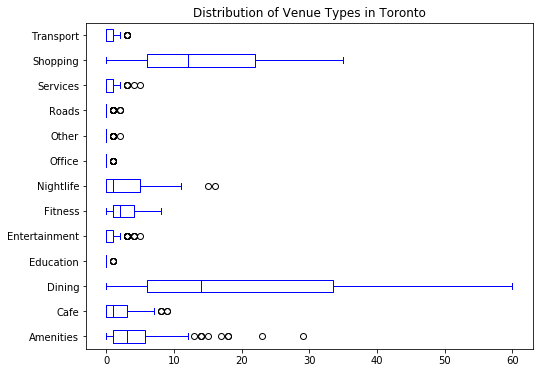

In [100]:
df_pivot2.plot(kind='box', figsize=(8, 6), color='blue', vert=False)
plt.title('Distribution of Venue Types in Toronto')
plt.show()

### For completeness, let's also rank postcodes by the number of popular venues from Foursquare

Calculate the sum of all venues returned from FourSquare API, in each postcode and plot on a bar chart.

Remember that FourSquare limits calls to 100 rows per call, so this data is clipped for those postcodes with many venues. We will assume that this will be fine for our purposes as we are using the 'Explore' API call to return the 100 most popular venues in each postcode.

In [169]:
sums = df_result.groupby('expl_pcode')['count_venues'].sum()
df_sum = sums.to_frame() 
df_sum.reset_index(inplace=True)
df_sum.head(1)

,expl_pcode,count_venues
0,M1B,14


In [178]:
df_sum_sorted = df_sum.sort_values(by=['count_venues'], ascending=True)
df_sum_sorted.set_index('expl_pcode', inplace=True)

In [234]:
df_sum_sorted.head(5)

,count_venues
expl_pcode,
M9W,4
M3M,4
M2L,4
M1C,5
M8Y,6


### Plot bar chart for total venues per postcode

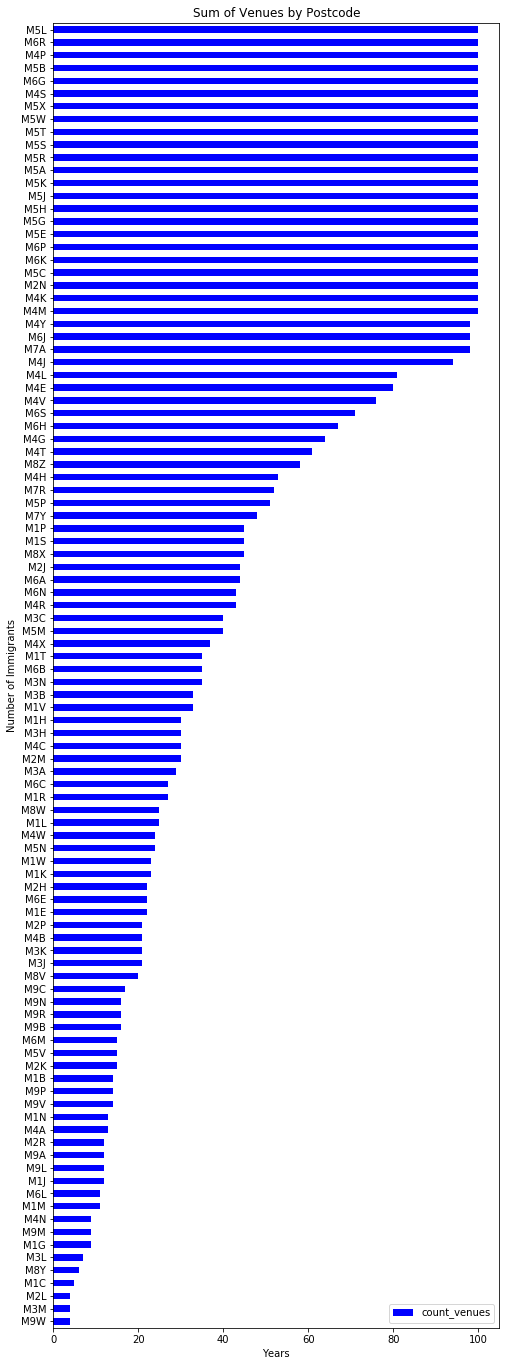

In [180]:
df_sum_sorted.plot(kind='barh', figsize=(8, 24), color='blue')
plt.title('Sum of Venues by Postcode')
plt.ylabel('Number of Immigrants')
plt.xlabel('Years')
plt.show()

### It seems our clients want to have a city lifestyle, but not be actually located in the CBD (near downtown area). 

##### Let's perform k-means clustering on all postcodes to see if we can find a postcode that is similar to downtown, but not actually located nearby. Venue types will be the characteristics used for clustering

In [194]:
# set number of clusters
kclusters = 5
df_pivot3 = df_pivot2.reset_index()
df_pivot3.head(1)

venue_type,expl_pcode,Amenities,Cafe,Dining,Education,Entertainment,Fitness,Nightlife,Office,Other,Roads,Services,Shopping,Transport
0,M1B,1.0,0.0,7.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0


In [201]:
grouped_clustering = df_pivot3.drop('expl_pcode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([4, 4, 0, 4, 0, 4, 0, 4, 4, 4, 2, 0, 2, 0, 0, 0, 0, 2, 4, 4, 0, 1,
       4, 4, 0, 0, 2, 0, 0, 0, 4, 4, 0, 4, 4, 0, 3, 2, 2, 1, 1, 3, 1, 4,
       1, 2, 1, 2, 2, 0, 0, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 2, 0, 2, 1, 1,
       1, 4, 3, 3, 2, 0, 0, 0, 1, 2, 1, 3, 4, 4, 0, 1, 3, 2, 1, 2, 2, 0,
       0, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

In [203]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

Insert labels for k-means clustering

In [ ]:
df_pivot3 = df_pivot3.insert(0, 'Cluster Labels', kmeans.labels_)

In [ ]:
df_pivot4 = df_pivot3[['expl_pcode','Cluster Labels']]
df_pivot4['Cluster Labels'] = df_pivot4['Cluster Labels'].astype(int)

In [230]:
# Merge 
merged2 = merged1.merge(df_pivot4, left_on='Postcode', right_on='expl_pcode', how='left')
merged2.fillna(0, inplace=True)
merged2['Cluster Labels'] = merged2['Cluster Labels'].astype(int)
merged2.head(5)

,Postcode,Borough,Neighbourhoods,Postal Code,Latitude,Longitude,expl_pcode,Cluster Labels
0,M3A,North York,Parkwoods,M3A,43.753259,-79.329656,M3A,0
1,M4A,North York,Victoria Village,M4A,43.725882,-79.315572,M4A,4
2,M5A,Downtown Toronto,Harbourfront,M5A,43.654260,-79.360636,M5A,3
3,M6A,North York,"Lawrence Heights, Lawrence Manor",M6A,43.718518,-79.464763,M6A,2
4,M7A,Queen's Park,Queen's Park,M7A,43.662301,-79.389494,M7A,1


### Finally, let's plot clusters on map to see if we can find our clients an area to look for property in!

##### Plot clusters on map

In [246]:
map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, pcode, bor, nhoods, cluster in zip(merged2['Latitude'], merged2['Longitude'], merged2['Postcode'], merged2['Borough'], merged2['Neighbourhoods'], merged2['Cluster Labels']):
    label = folium.Popup(str(pcode) + ' || ' + str(bor) + ' || ' + str(nhoods) + ' || ' + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### It seems we have done it! 

## Outcome: Willowdale South, in North York (postcode = M2N) will be perfect for our client's buyers.

Willowdale South has similar characteristics to downtown Toronto, but unlike under areas in this Cluster (1), it is located about 30 mins drive from the downtown area. This ticks all the boxes for our buyers, and is the neighbourhood we should recommend to our buyers to begin their property search.

### However, we should also attempt to validate this by Scoring each postcode according to the criteria provided by our clients (below)

Remember, our buyers told us: <i>"We spend about 30% of our time dining our, and probably the same again going our to bars and other nightlife, and public amenities like parks and musuems. We spend about 20% of our time shopping, and divide the remainder equally between fitness and entertainment"</i>

We will approximate this mathematically as a linear model:

Score = 0.3 * Dining + 0.3 * (Nightlife + Amenities) + 0.2 * Shopping + 0.1 * Fitness + 0.1 * Entertainment 

Once calculated, we will use this score to rank postcodes by our clients requirements, and see how Willowdale South ranks in the Scoring....

In [251]:
# Score = 0.3 * Dining + 0.2 * Shopping + 0.3 * (Nightlife + Amenities) + 0.1 * Entertainment + 0.1 * Fitness
df_score0 = (0.3 * df_pivot3['Dining'] + 0.3 * (df_pivot3['Nightlife'] + df_pivot3['Amenities']) + 0.2 * df_pivot3['Shopping'] + 0.1 * df_pivot3['Fitness'] + 0.1 * df_pivot3['Entertainment']).to_frame()
df_score0.columns = ['score']

In [269]:
df_score1 = df_pivot3.sort_values(by=['score'], ascending=False)

In [278]:
df_score1.head(10)

venue_type,score,Cluster Labels,expl_pcode,Amenities,Cafe,Dining,Education,Entertainment,Fitness,Nightlife,Office,Other,Roads,Services,Shopping,Transport
Index,,,,,,,,,,,,,,,,
0,25.4,1,M2N,4.0,3.0,60.0,0.0,2.0,4.0,4.0,0.0,0.0,0.0,1.0,22.0,0.0
1,24.9,3,M5L,17.0,7.0,44.0,0.0,0.0,4.0,8.0,0.0,0.0,0.0,0.0,19.0,1.0
2,24.8,3,M5K,23.0,7.0,41.0,0.0,3.0,4.0,7.0,0.0,0.0,0.0,0.0,14.0,1.0
3,24.5,1,M6J,8.0,8.0,43.0,0.0,1.0,1.0,16.0,0.0,0.0,0.0,0.0,21.0,0.0
4,24.5,3,M5J,29.0,5.0,29.0,0.0,2.0,8.0,11.0,0.0,1.0,0.0,0.0,14.0,1.0
5,24.4,1,M4Y,10.0,3.0,46.0,0.0,1.0,6.0,7.0,0.0,0.0,0.0,1.0,24.0,0.0
6,24.4,1,M7A,9.0,3.0,47.0,0.0,3.0,4.0,5.0,0.0,0.0,0.0,0.0,27.0,0.0
7,24.4,1,M4S,3.0,3.0,52.0,0.0,4.0,5.0,6.0,0.0,0.0,0.0,1.0,26.0,0.0
8,24.3,3,M5C,15.0,7.0,41.0,0.0,1.0,3.0,5.0,0.0,0.0,0.0,0.0,28.0,0.0


# Our k-means result is validated! 

### Conclusion: Willowdale South, in the distrinct of North York (postcode = M2N) will be recommended to our client's buyers!

Willowdale South also has the <u><b>highest score</u></b> based on our linear model! 

In [1]:
df_result1.loc[df_result1['Postcode'] == 'M2N']

NameError: name 'df_result1' is not defined

## Thank you for reviewing my assignment! :)